In [1]:
import os
import pickle
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image


import torchvision.transforms as transforms

# Define transform to resize images
transform = transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor()
])

class CustomDataset(Dataset):
    def __init__(self, filename, transform=None):
        with open(filename, 'rb') as f:
            data = pickle.load(f)
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = self.data[idx]['img_path']
        label = self.data[idx]['class_label']
        
        # Load PIL image
        img = Image.open(img_path)
        
        # Apply transform
        if self.transform:
            img = self.transform(img)
        
                # Check image size
        if img.size != (3, 480, 480):
            print(img.size)
            return None
        
        return img, label

# Create dataloader object
batch_size = 32



train_set = CustomDataset(filename='train.pkl', transform=transform)
test_set = CustomDataset(filename='test.pkl', transform=transform)
val_set = CustomDataset(filename='val.pkl', transform=transform)


train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

c:\Users\zuzal\anaconda3\envs\mlops\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset loader from bottleneck concept script

In [2]:
from dataset import load_data

train_data_path=r"C:\Users\zuzal\Masters\Responsible_AI\XAI\CNN\train.pkl"
val_data_path=r"C:\Users\zuzal\Masters\Responsible_AI\XAI\CNN\val.pkl"

train_loader = load_data([train_data_path], use_attr=False, no_img=False, batch_size=64, uncertain_label=False, image_dir="", n_class_attr=0)
val_loader = load_data([val_data_path], use_attr=False, no_img=False, batch_size=64, uncertain_label=False, image_dir="", n_class_attr=0)

In [3]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load the pre-trained ResNet18 model
model = models.resnet18(weights='DEFAULT')

# Modify the last layer to match the number of classes in the CUB dataset
num_classes = 200
model.fc = nn.Linear(model.fc.in_features, num_classes)


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Define the device to use for computation (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Define the number of epochs to train for
num_epochs = 10

# Train the model
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Train one epoch
    train_loss = 0.0
    train_acc = 0.0
    train_size = 0
    for images, labels in train_loader:
        # Move the data to the device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update the training loss and accuracy
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_acc += accuracy_score(preds.cpu().numpy(), labels.cpu().numpy()) * images.size(0)
        train_size += images.size(0)

    train_loss /= train_size
    train_acc /= train_size

    # Set the model to evaluation mode
    model.eval()

    # Evaluate one epoch
    val_loss = 0.0
    val_acc = 0.0
    val_size = 0
    with torch.no_grad():
        for images, labels in val_loader:
            # Move the data to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # Update the validation loss and accuracy
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_acc += accuracy_score(preds.cpu().numpy(), labels.cpu().numpy()) * images.size(0)
            val_size += images.size(0)

    val_loss /= val_size
    val_acc /= val_size

    # Print the results for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}: "
          f"train_loss={train_loss:.4f} "
          f"train_acc={train_acc:.4f} "
          f"val_loss={val_loss:.4f} "
          f"val_acc={val_acc:.4f}")

c:\Users\zuzal\anaconda3\envs\mlops\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10: train_loss=4.9722 train_acc=0.0355 val_loss=4.5012 val_acc=0.0518
Epoch 2/10: train_loss=4.0221 train_acc=0.1106 val_loss=4.2354 val_acc=0.1035
Epoch 3/10: train_loss=3.3970 train_acc=0.1993 val_loss=3.2840 val_acc=0.1811
Epoch 4/10: train_loss=2.9636 train_acc=0.2684 val_loss=3.3148 val_acc=0.2295
Epoch 5/10: train_loss=2.6713 train_acc=0.3347 val_loss=2.6165 val_acc=0.3189
Epoch 6/10: train_loss=2.3612 train_acc=0.4035 val_loss=3.4322 val_acc=0.2396
Epoch 7/10: train_loss=2.1324 train_acc=0.4590 val_loss=2.2228 val_acc=0.4265
Epoch 8/10: train_loss=1.9590 train_acc=0.4996 val_loss=1.8463 val_acc=0.4942
Epoch 9/10: train_loss=1.8183 train_acc=0.5370 val_loss=2.0371 val_acc=0.4674
Epoch 10/10: train_loss=1.7394 train_acc=0.5566 val_loss=1.8945 val_acc=0.5100


In [4]:
torch.save(model.state_dict(), 'resnet18_trained.pth')

In [10]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

model = models.resnet18()
num_classes = 200
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('resnet18_trained.pth'))



<All keys matched successfully>

In [11]:
import torch
from torch.autograd import Variable

def compute_saliency_maps(images, labels, model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Convert the images and labels to variables
    images = Variable(images, requires_grad=True)
    labels = Variable(labels)

    # Forward pass
    output = model(images)
    loss = torch.nn.functional.cross_entropy(output, labels)

    # Backward pass
    loss.backward()

    # Get the gradients of the input with respect to the loss
    gradients = images.grad.data

    # Absolute value of the gradients
    gradients = torch.abs(gradients)

    # Max of the gradients across the channels
    gradients, _ = torch.max(gradients, dim=1)

    # Normalize the gradients
    gradients = torch.div(gradients, torch.max(gradients))

    return gradients

In [12]:
import matplotlib.pyplot as plt
import numpy 
import cv2

test_data_path = r"C:\Users\zuzal\Masters\Responsible_AI\XAI\CNN\test.pkl"
test_loader = load_data([test_data_path], use_attr=False, no_img=False, batch_size=64, uncertain_label=False, image_dir="", n_class_attr=0)
# Choose a few images from the test set
img_list=[]

for images, labels in test_loader:

# Compute the saliency maps
    saliency_maps = compute_saliency_maps(images, labels, model)

# Plot the original images and their saliency maps
for i in range(5):
    # Convert the saliency map to a heatmap and normalize it between 0 and 1
    heatmap = np.uint8(255 * saliency_maps[i]/np.max(saliency_maps[i]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Resize the heatmap to the size of the original image
    heatmap = cv2.resize(heatmap, (images.size(-1), images.size(-2)))
    heatmap = np.transpose(heatmap, (2, 0, 1))

    # Overlay the heatmap on the original image
    cam = heatmap + np.float32(images[i].squeeze().numpy().transpose((1, 2, 0)))
    cam = cam / np.max(cam)
    plt.figure()
    plt.subplot(121)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(cam)
    plt.axis('off')
    plt.show()


TypeError: max() received an invalid combination of arguments - got (axis=NoneType, out=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, out
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: axis, out


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


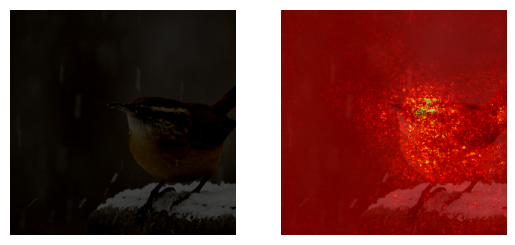

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


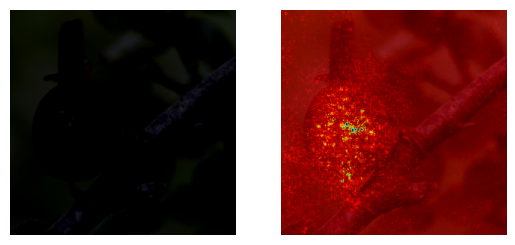

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


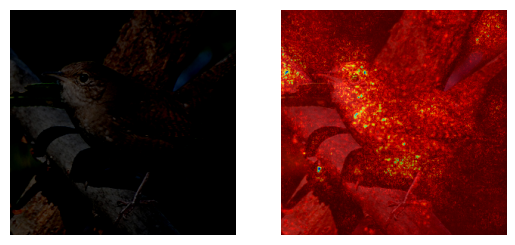

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


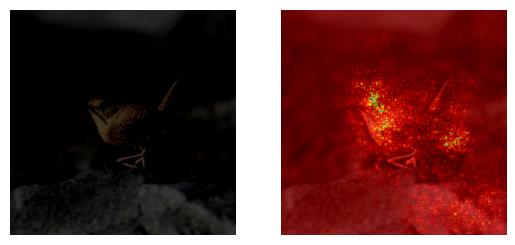

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


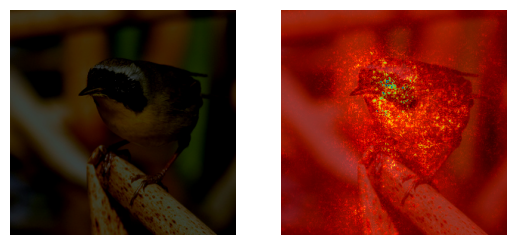

In [33]:
# Plot the original images and their saliency maps

#saliency_maps=saliency_maps.numpy().transpose(1, 2, 0)

saliency_maps=saliency_maps.transpose(1, 2, 0)

for i in range(5):
    # Convert the saliency map to a heatmap and normalize it between 0 and 1
    heatmap = np.uint8(255 * saliency_maps[:,:, i]/np.max(saliency_maps[:,:, i]))
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255

    # Resize the heatmap to the size of the original image
    heatmap = cv2.resize(heatmap, (images.size(-1), images.size(-2)))
    #heatmap = np.transpose(heatmap, (2, 0, 1))

    # Overlay the heatmap on the original image
    cam = heatmap + np.float32(images[i].squeeze().numpy().transpose((1, 2, 0)))
    cam = cam / np.max(cam)
    plt.figure()
    plt.subplot(121)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(cam)
    plt.axis('off')
    plt.show()

In [30]:
saliency_maps[:,:, i].shape

(299, 299)